In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
df=pd.read_csv('telecom_users.csv')
df['alone']=df.apply(lambda x: int(not any([x.Partner=='Yes',x.Dependents=='Yes'])),axis=1)
for c in [ 	'PhoneService' ,	'MultipleLines' 	,'OnlineSecurity' ,	'OnlineBackup' ,	'DeviceProtection' ,	'TechSupport', 	'StreamingTV' ,	'StreamingMovies' 	, 	 'Churn','PaperlessBilling']:
    df[c]=df[c].apply(lambda x: 1 if (x=='Yes') else 0)
df['InternetService']=df['InternetService'].apply(lambda x: 1 if not (x=='No') else 0)
df['female']=df['gender'].apply(lambda x: 1 if not (x=='Male') else 0)
df['autopay']=df.apply(lambda x: 1 if (('automatic' in x['PaymentMethod'])and(x.PaperlessBilling)) else 0,axis=1)
df['addedservices']=df.apply(lambda x: sum([x.OnlineSecurity,x.OnlineBackup,x.DeviceProtection,x.TechSupport,x.MultipleLines,x.StreamingTV,x.StreamingMovies]),axis=1)
ohe = LabelBinarizer()
ohe.fit(df[['Contract']])
transformed = ohe.transform(df[['Contract']])
t_df=pd.DataFrame(transformed)
df= pd.concat([df,t_df],axis=1)
df.rename(columns={0:df.Contract.unique()[1],1:df.Contract.unique()[2],2:df.Contract.unique()[0]},inplace=True)
df.drop(columns=['Unnamed: 0','customerID','TotalCharges','Partner','Dependents','gender','PaymentMethod','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','MultipleLines','StreamingTV','StreamingMovies','PaperlessBilling','Contract'], inplace=True)
df.head(5)

,SeniorCitizen,tenure,PhoneService,InternetService,MonthlyCharges,Churn,alone,female,autopay,addedservices,Month-to-month,One year,Two year
0,0,72,1,0,24.10,0,0,0,0,1,0,0,1
1,0,44,1,1,88.15,0,1,1,1,3,1,0,0
2,1,38,1,1,74.95,1,0,1,1,1,1,0,0
3,0,4,1,1,55.90,0,1,0,0,1,1,0,0
4,0,2,1,1,53.45,0,1,0,0,2,1,0,0


In [3]:
X = df.drop(columns=['Churn'])
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [4]:
y.reset_index().groupby('Churn').count()

,index
Churn,
0,4399
1,1587


In [5]:
#pipeline = Pipeline(steps=[("scaler", StandardScaler()), ("model", BernoulliNB(class_weight='balanced'))])
#pipeline = Pipeline(steps=[("scaler", StandardScaler()), ("model", LogisticRegression(random_state=42,class_weight='balanced'))])
ratio=0.245
pipeline = Pipeline(steps=[("scaler", StandardScaler()), ("model", LogisticRegression(random_state=42,class_weight={0:ratio ,1:1-ratio}))])
pipeline.fit(X_train.values, y_train.values)
y_pred = pipeline.predict(X_test.values)
class_labels = pipeline.named_steps['model'].classes_
score=np.mean(cross_val_score(pipeline, X_train, y_train, scoring="recall", cv=5))
print(score)
print(classification_report(y_test, y_pred))

0.8163899325334303
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1320
           1       0.50      0.80      0.61       476

    accuracy                           0.73      1796
   macro avg       0.70      0.75      0.70      1796
weighted avg       0.80      0.73      0.75      1796



In [6]:
explainer = shap.KernelExplainer(pipeline.predict, X_train)

Using 4190 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [7]:
shap_values = explainer.shap_values(shap.sample(X_test,30))

  0%|          | 0/30 [00:00<?, ?it/s]

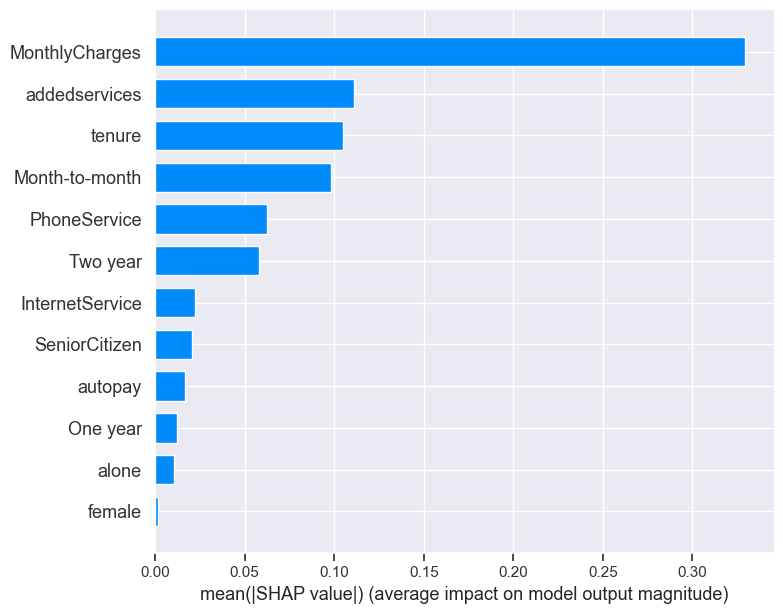

In [12]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

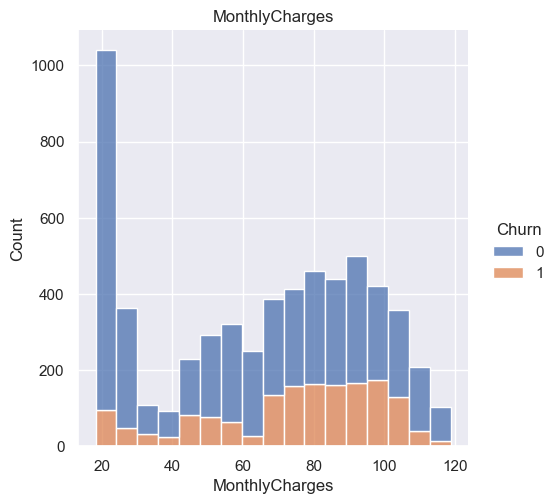

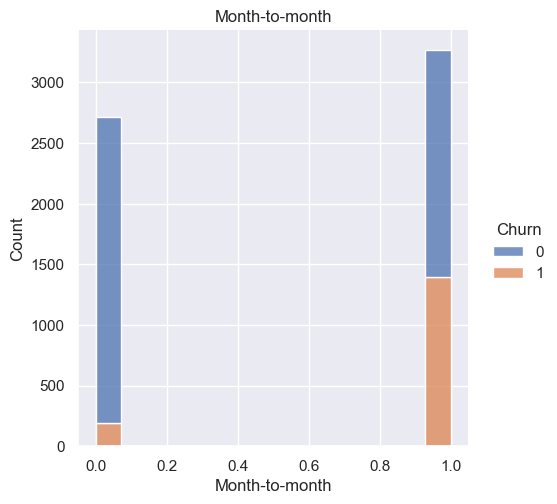

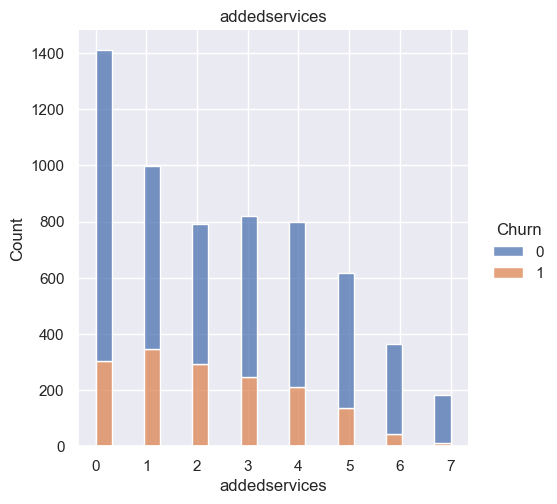

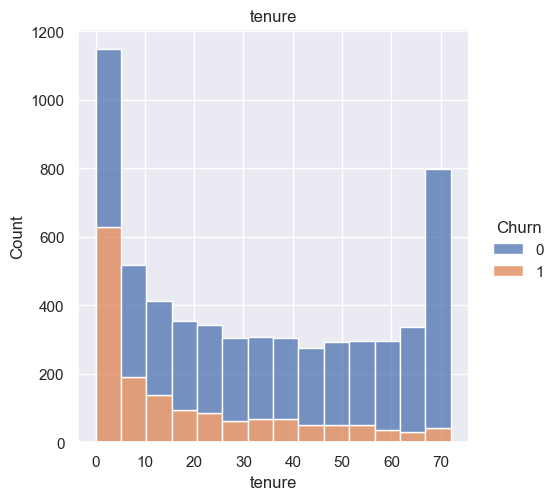

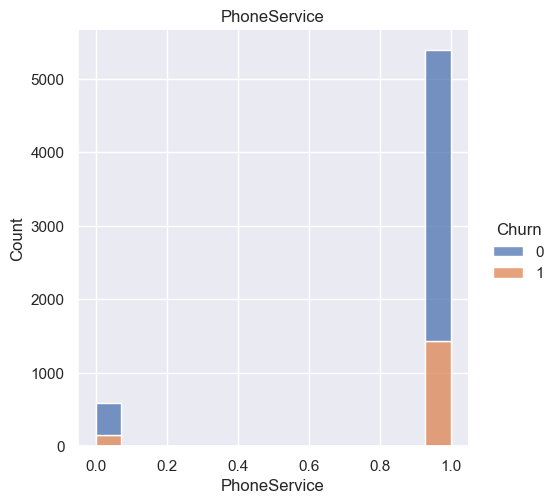

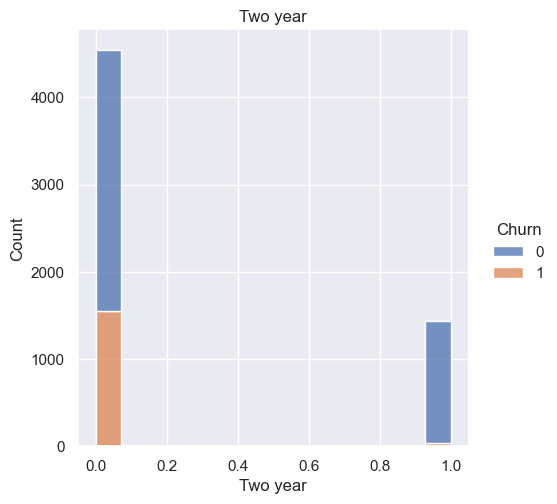

In [9]:
#sns.histplot(df['MonthlyCharges'])
sns.set(rc={'figure.figsize':(5,5)})
for i in ['MonthlyCharges','Month-to-month','addedservices','tenure','PhoneService','Two year']:
    sns.displot(df, x=i, hue="Churn", multiple="stack").set(title=i)


In [13]:
shap.initjs()
c=6
shap.force_plot(explainer.expected_value, shap_values[c, :], X_test.iloc[c, :])


In [14]:
c=8
shap.force_plot(explainer.expected_value, shap_values[c, :], X_test.iloc[c, :])